# Mitigating Noise on Real Quantum Computers

In [14]:
from qiskit import *
from qiskit.visualization import plot_histogram
from qiskit.tools.monitor import job_monitor
IBMQ.load_account()

Credentials are already in use. The existing account in the session will be replaced.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

## Correcting noice on 3-Qbit circuit

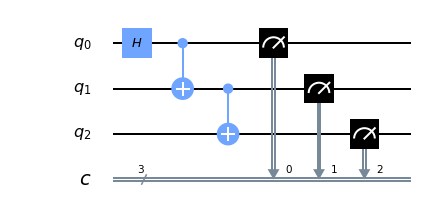

In [16]:
# Creating a quantum circuit
circuit = QuantumCircuit(3, 3)
circuit.h(0)
circuit.cx(0, 1)
circuit.cx(1, 2)
circuit.measure([0,1,2], [0,1,2])
%matplotlib inline
circuit.draw(output='mpl')

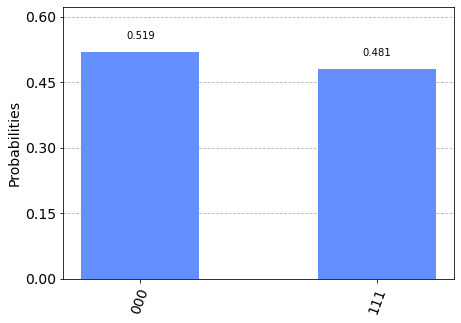

In [17]:
simulator = Aer.get_backend('qasm_simulator')
sim_result = execute(circuit, backend=simulator, shots=1024).result()
plot_histogram(sim_result.get_counts(circuit))

In [18]:
provider = IBMQ.get_provider(hub='ibm-q')
device = provider.get_backend('ibmqx2')

In [19]:
job = execute(circuit, backend=device, shots=1024)
print(job.job_id())
job_monitor(job)

5e88066d4868d60018b1bf2f
Job Status: job has successfully run


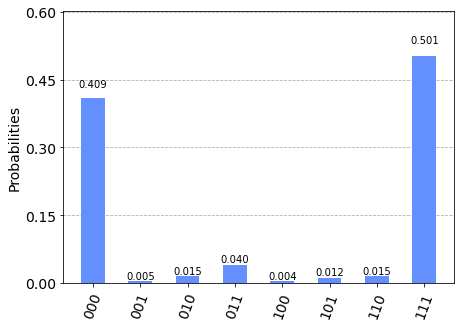

In [20]:
device_result = job.result()
plot_histogram(device_result.get_counts(circuit))

In [21]:
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, CompleteMeasFitter)
cal_circuits, state_labels = complete_meas_cal(qr = circuit.qregs[0], circlabel = 'measerrormitigationcal')

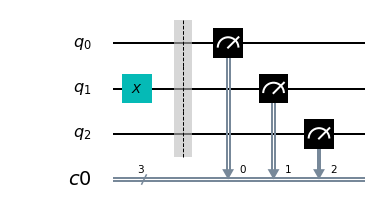

In [23]:
cal_circuits[2].draw(output='mpl')

In [26]:
cal_job = execute(cal_circuits,
                 backend=device,
                 shots=1024,
                 optimization_level = 0)
print(cal_job.job_id())
job_monitor(cal_job)
cal_results = cal_job.result()

5e88092c4868d60018b1bf43
Job Status: job has successfully run


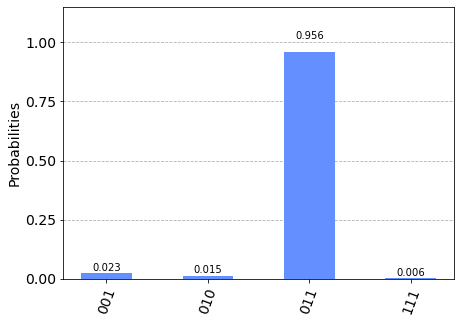

In [30]:
plot_histogram(cal_results.get_counts(cal_circuits[3]))

In [31]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels)

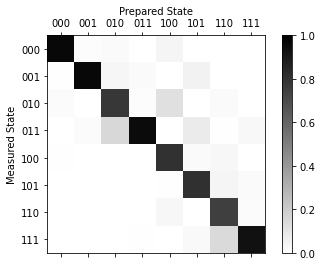

In [32]:
meas_fitter.plot_calibration()

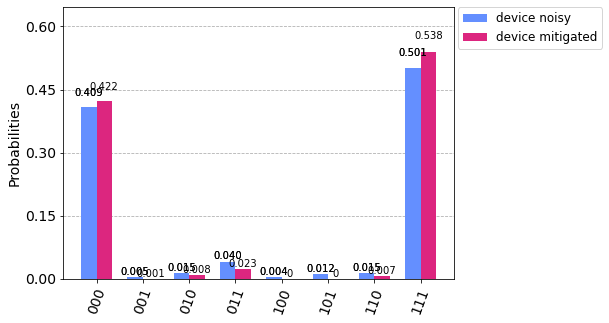

In [33]:
meas_filter = meas_fitter.filter
mitigated_result = meas_filter.apply(device_result)

device_counts  = device_result.get_counts(circuit)
mitigated_counts = mitigated_result.get_counts(circuit)
plot_histogram([device_counts, mitigated_counts], legend=['device noisy','device mitigated'])

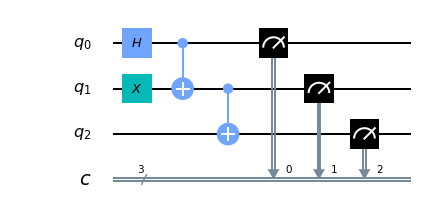

In [34]:
new_circuit = QuantumCircuit(3, 3)
new_circuit.x(1)
new_circuit.h(0)
new_circuit.cx(0, 1)
new_circuit.cx(1, 2)
new_circuit.measure([0,1,2], [0,1,2])
new_circuit.draw(output='mpl')

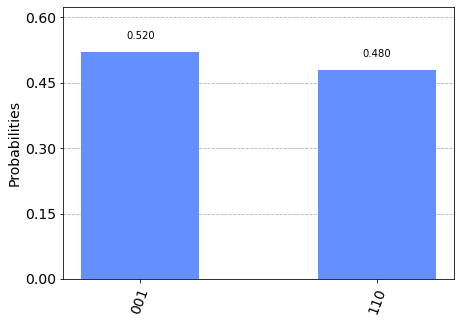

In [35]:
plot_histogram(
    execute(new_circuit, backend=simulator,
            shots=1024).result().get_counts(new_circuit)
)

In [39]:
new_job = execute(new_circuit, backend=device, 
                  shots=1024).result().get_counts(new_circuit)

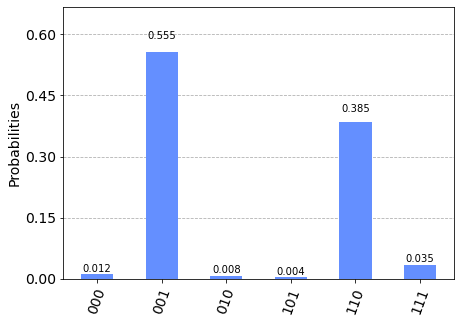

In [40]:
plot_histogram(meas_filter.apply(new_job))